<a id="0"></a>
1. [Task](#1)
2. [Preparing the Grover diffusion operator and the Coin operator](#2)
3. [Preparing Shift Operator (S)](#3)
4. [Main Function](#4)
5. [Synthesize with constraints](#5)
6. [Synthesize without constraints)](#6)


<a id="1"></a>
# Task
Follow the example from [Bootcamp](https://www.youtube.com/watch?v=kHJLwfDUSWI&list=PL_wGNAk5B0pXq98BJBKsbNH2Qjp1lk8dG&index=32) for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes:

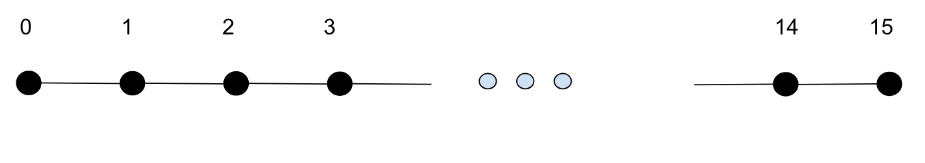

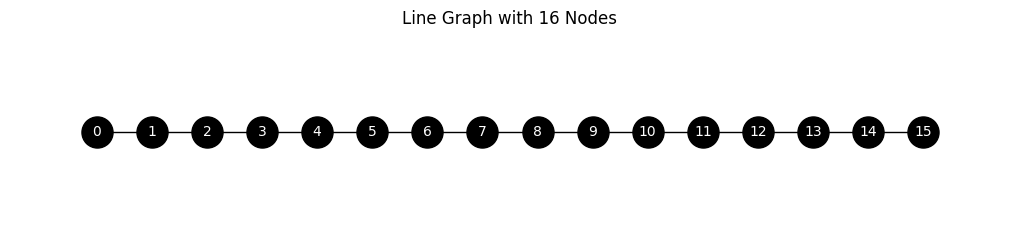

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph
G = nx.Graph()

# Add nodes and edges for the line graph
nodes = list(range(16))
edges = [(i, i+1) for i in range(15)]

G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Position the nodes in a line layout
pos = {i: (i, 0) for i in nodes}

# Draw the graph
plt.figure(figsize=(10, 2))
nx.draw(G, pos, with_labels=True, node_color='black', node_size=500, font_color='white', font_size=10, edge_color='black')
plt.title("Line Graph with 16 Nodes")
plt.show()

In [2]:
from classiq import *
size = 4

We have a graph $G = (V,E)$,where $V = \{0,1,2, \dots, 15,16\} $ and $E = \{(0,1), (1,2), (2,3), \dots, (14,15), + \text{symm.}\}$.
So comparing with the example we need to adapt the `W_iteration`, which is a unitary transformation that operates on the second register conditional on the first register. This transformation is sometimes referred to as a “coin flip,” as it modifies the next destination of the walker. Next, the walker is moved to the vertex indicated in the second register, so we need to adapt `edge_oracle` to our graph.

<a id="2"></a>
## Preparing the Grover diffusion operator and the Coin operator
The W_operator applies the W_iteration function to each vertex, preparing a superposition state where the walker is probabilistically ready to move to adjacent vertices based on the graph structure. The W_iteration function is essential for defining the possible directions the walker can move, while the zero_diffuzer function helps to amplify the desired paths, increasing the likelihood of finding the walker in certain states.

Mathematically, a common choice for the coin operator is the Grover diffusion operator applied over the neighbors of vertex $j$, namely:
$$C = \sum_{j \in V} |j\rangle\langle j| \otimes \left( 2|\partial_j\rangle\langle \partial_j| - I \right),$$
where the Grover diffusion operator acts on the second set of registers, controlled by the first set of registers. This operator modifies the walker's superposition state, amplifying certain paths and thereby influencing the walker's subsequent movement on the graph.

In [3]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(within=lambda: prepare_minus(aux),
                 apply=lambda: diffuzer_oracle)
def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0] * (2 ** size)  # Initialize probability vector for 16 nodes (2^4 = 16)

    if i == 0:
        prob[i + 1] = 1.0  # Move right with certainty if at the first node
    elif i == (2 ** size) - 1:
        prob[i - 1] = 1.0  # Move left with certainty if at the last node
    else:
        prob[i - 1] = 0.5  # Move left with 50% probability
        prob[i + 1] = 0.5  # Move right with 50% probability

    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices == i,
            stmt_block=lambda: within_apply(
                within=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                apply=lambda: zero_diffuzer(adjacent_vertices)))

In [4]:
@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i,vertices,adjacent_vertices)

<a id="3"></a>
## Preparing Shift Operator (S)
The following function is responsible for checking whether an edge exists between two vertices, i.e., whether the vertices are adjacent in the graph. It returns True if there is an edge connecting the vertex and its adjacent vertex. If this condition is satisfied, the function performs a bitwise SWAP operation between the two vertices. This operation ensures that the quantum walk respects the structure of the graph by only allowing transitions between adjacent vertices.
Mathematically, this operation is an implementation of the shift operator $S$ in a quantum walk, defined as:
$$S = \sum_{(j,k) \in E} |j,k\rangle\langle k,j|,$$
where the sum is taken over all pairs of adjacent vertices $(j,k)$ in the graph, represented by the edge set $E$. The shift operator $S$ swaps the state $|j,k\rangle$ with $|k,j\rangle$, effectively moving the walker from one vertex to its adjacent vertex. This operation is fundamental in quantum walks, as it allows the quantum walker to traverse the graph while preserving the adjacency relationships defined by the edges of the graph.

In [5]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))
@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i]))
@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
            stmt_block= lambda: bitwise_swap(vertices,adjacent_vertices))

<a id="4"></a>
## Main Function
The main function sets up and executes the quantum walk. It begins by initializing the quantum system, applying a Hadamard transform to the vertices to place the walker in a superposition of all possible starting states. This superposition allows the quantum walker to explore multiple paths simultaneously. The function then allocates the required qubits for both the vertices and their adjacent vertices. Following this initialization, the function applies the `W_operator` (the coin operation) to determine the walker's potential moves and the `S_operator` (the shift operation) to move the walker across the graph according to the established superposition. Together, these operations implement one step of the quantum walk on the graph.

In [6]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

    allocate(size,vertices)
    hadamard_transform(vertices)
    allocate(size,adjacent_vertices)

    W_operator(vertices,adjacent_vertices)
    S_operator(vertices,adjacent_vertices)

<a id="5"></a>
## Synthesize with constraints

In [7]:
qmod = create_model(main)
quantum_model_with_constraints = set_constraints(
    qmod, Constraints(optimization_parameter="width", max_depth=10000)
)
qprog = synthesize(quantum_model_with_constraints)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

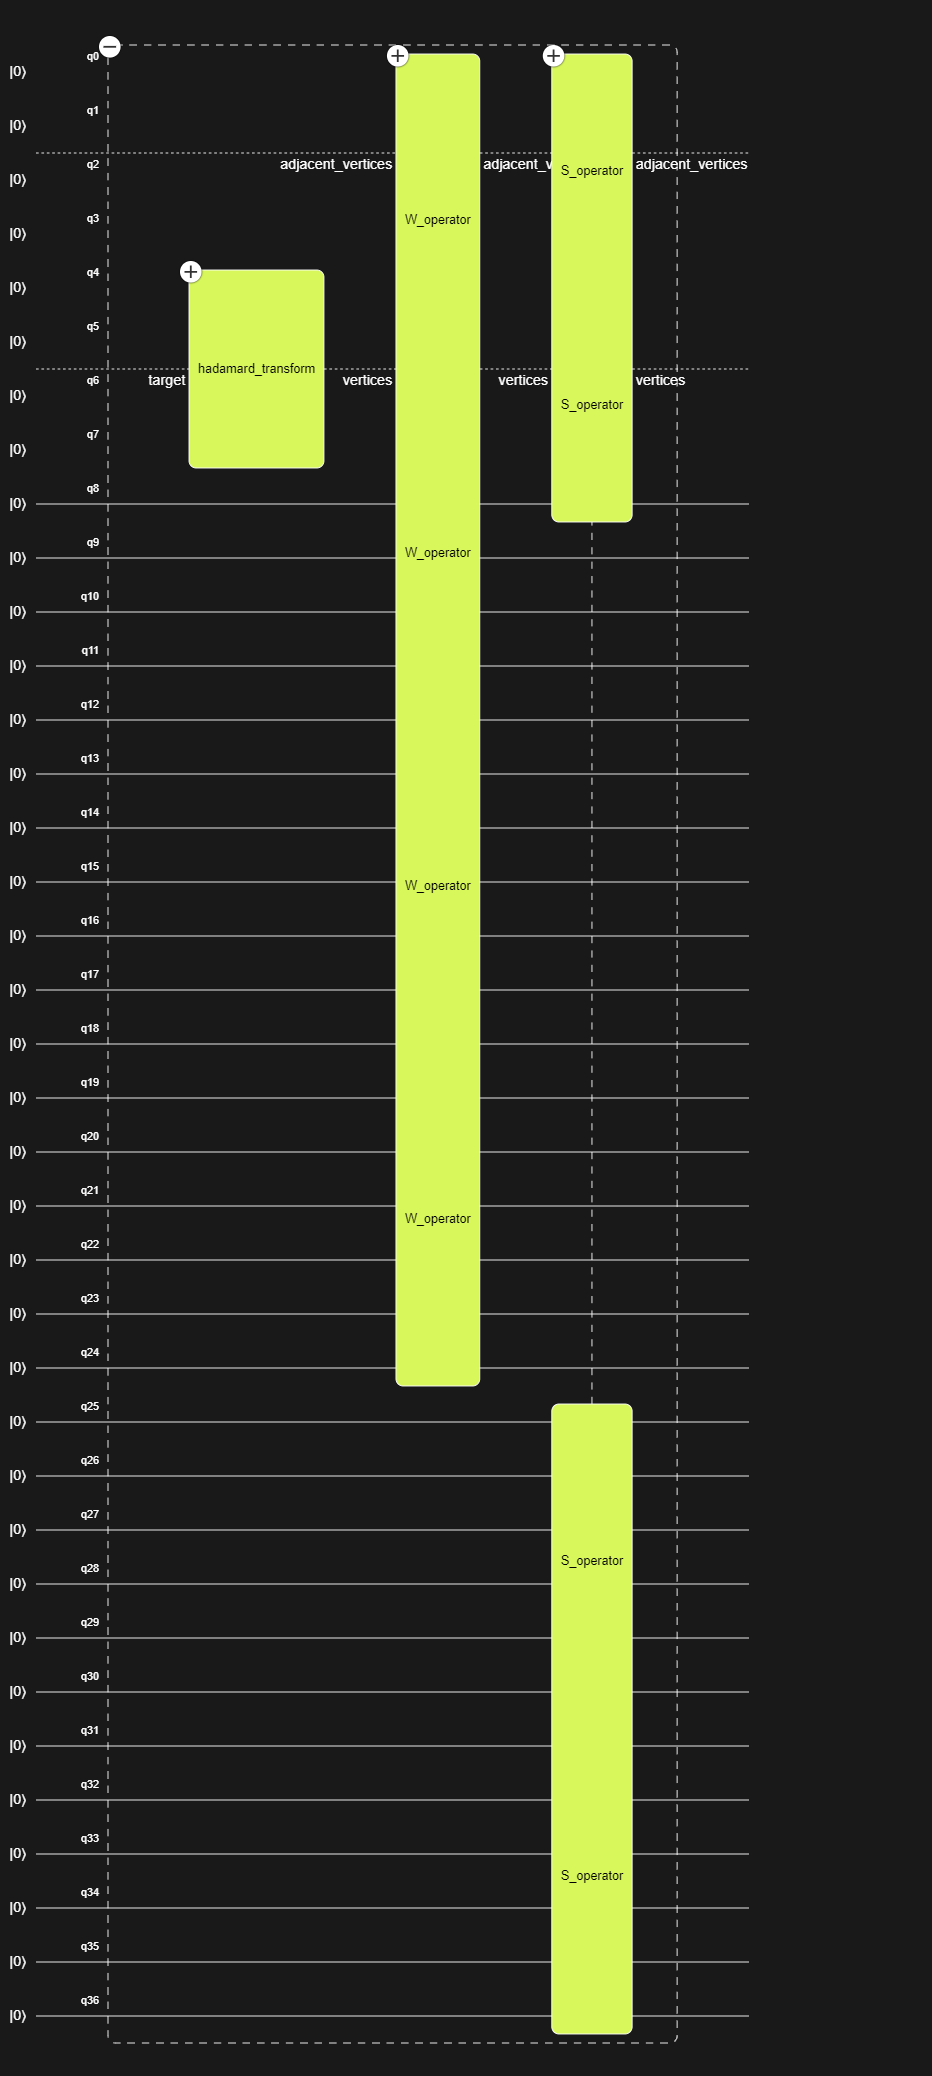

Depth: 2778
Width: 37

<a id="6"></a>
## Synthesize without constraints

In [8]:
qmod_2 = create_model(main) # create a model
qprog_2 = synthesize(qmod_2) # synthesize it
show(qprog_2) # display the circuit

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

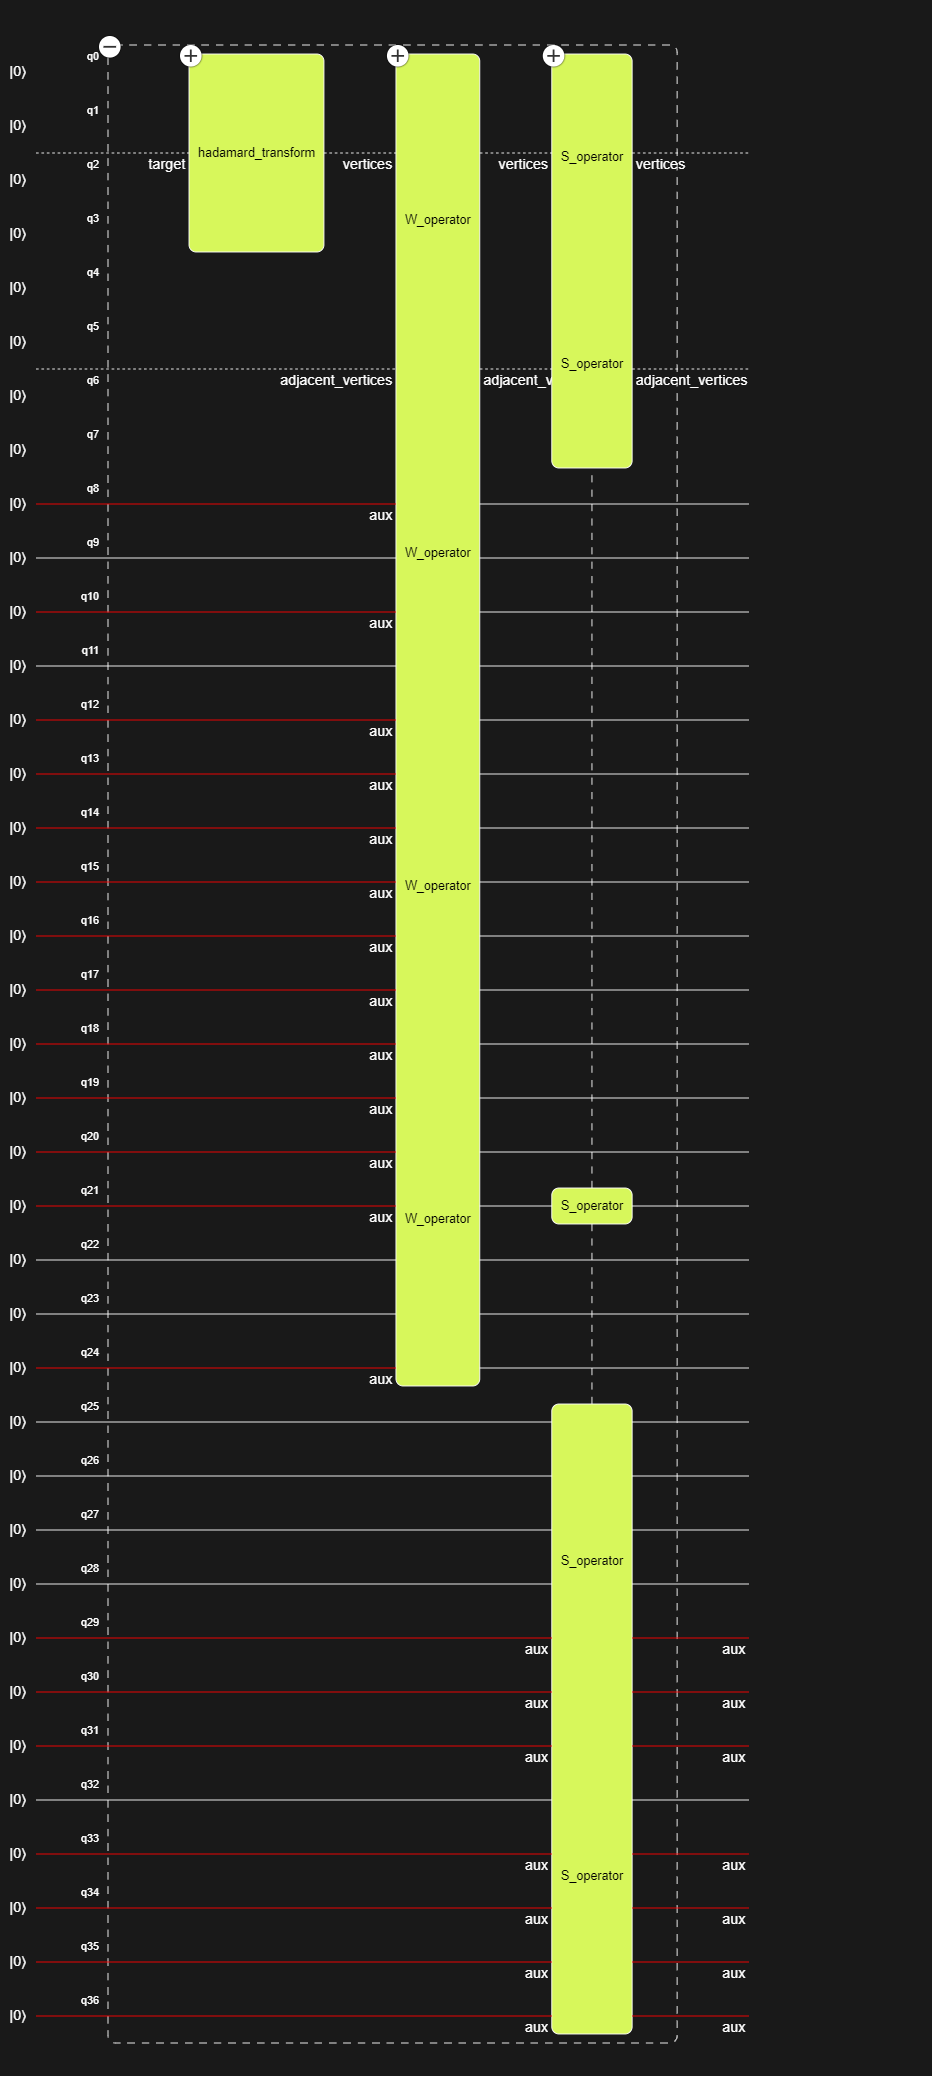

Depth: 3190
Width: 37